### 比賽名稱:
House Prices - Advanced Regression Techniques

### 比賽簡介:
這個比賽是我在Kaggle上的"Getting Started"標籤區中找到的，因為這個題目與上課老師教過的房價預測類似，而且我覺得我對於機器學習的知識量還不夠，所以我想先從入門的比賽開始邊學邊做。  
資料集總共有三個，分別是train.csv、test.csv、data_description.txt，train.csv是訓練集，test.csv是測試集，data_description.txt是對於每個特徵值及數據類型的說明。  
目標是要預測每個房地產的價格，提交的預測數據會由"Root-Mean-Squared-Error(RMSE-均方根誤差)"評估，得到的預測分數越低代表越準確。

### 比賽過程:
第一次的預測大部分只參考了課堂講義「House Price Prediction & Titanic Survival Prediction」及「Titanic to Kaggle」。  
由於資料集的特徵值非常多，我遇到了許多難題，我盯著講義看了很久還是不知道怎麼做，第一個是怎麼進行有效率的資料觀察。第二個是怎麼處理遺漏值，我的作法是把遺漏值過大的column直接刪除，然後把還存在Nan的row全部刪除，這個做法可以說是相當粗暴。第三個是怎麼處理離散的類別，我上網查了[這篇文章](https://ithelp.ithome.com.tw/articles/10272964)，並且使用了迴圈對每個型別為object的欄位進行LabelEncoder的轉換。此問題為回歸問題，我就選擇使用了scikit-learn的LinearRegression來進行預測，但因為沒有經過交叉驗證的挑選，所以分數不是很好看。

因為我希望能讓預測分數好看一點，所以決定進行第二次的預測，我去找了網路上的文章來參考([文章來源](https://chenchenhouse.com/kaggle/))。我首先照著文章修改了遺漏值的處理方法，先將遺漏值可視化，然後分析每個遺漏值適用的補值方法並補上，再把幾乎沒影響的特徵值刪除。接著是特徵前處理，文章使用的方法是分析每個離散特徵值的平均數、中位數及數量來進行數值轉換及排序，由於這個方法要花大量的時間進行分析，所以我還是沿用LabelEncoder來進行離散特徵值的轉換，而對連續型特徵值則是採用log來標準化。接下來對預測目標也就是房價利用Q-Q圖(分位圖)觀察，發現房價出現了厚尾的現象，代表出現極端離群值的機率較高，因此要使用log轉換讓數值範圍縮小。數據處理好後，使用RandomForestRegressor(隨機回歸森林)、ExtraTreesRegressor(極端隨機森林)GradientBoostingRegressor(梯度提升回歸樹)及第一次預測所使用的LinearRegression(線性迴歸)這四種模型利用cross_val_score進行交叉驗證來決定RMSE最低的模型，經過for迴圈的訓練與預測後，結果第一次使用的線性迴歸模型RMSE是最高的，而梯度提升回歸樹的RMSE最低，所以就選擇它來當作預測模型。最後就將預測出來的結果存成csv檔提交到kaggle上。

### 比賽結果:
我總共提交了三次預測  
第一次的預測分數為0.17372，排名沒記錄到，大概記得是3000多名  
第二次由於格式錯誤，提交失敗  
重新修正格式後，第三次的預測分數為0.13382  
現在(2023/4/15 17:00)，第三次的分數0.13382在排行榜上位居1265名，總人數為4553，Top 28%

### 結論  
雖然第一次預測到第二次的排名上升許多，不過這並不表示我的預測分數已經是最好的，還有許多可以嘗試的方法，例如可以再找更多的模型進行交叉驗證來找到說不定表現更好的模型，或是透過調整原始模型的參數來讓預測成績上升，也可以對題目提供的資料集進行更完整的清洗和調整，像我這次就沒有針對每個特徵值進行個別的分析與轉換，因為那真的太花時間了，但我推測如果如果這麼做的話，排名應該能進到前1000名。

註:本報告無使用任何AI產生之內容

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train_data = pd.read_csv("C:/Users/123/Documents/VSCode/ML/Kaggle/House_Prices/Dataset/train.csv",index_col="Id")
test_data = pd.read_csv('C:/Users/123/Documents/VSCode/ML/Kaggle/House_Prices/Dataset/test.csv',index_col="Id")

In [122]:
#將train與test的資料合併
train = train_data.drop("SalePrice", axis=1)
all_data= pd.concat((train, test_data))
all_data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml


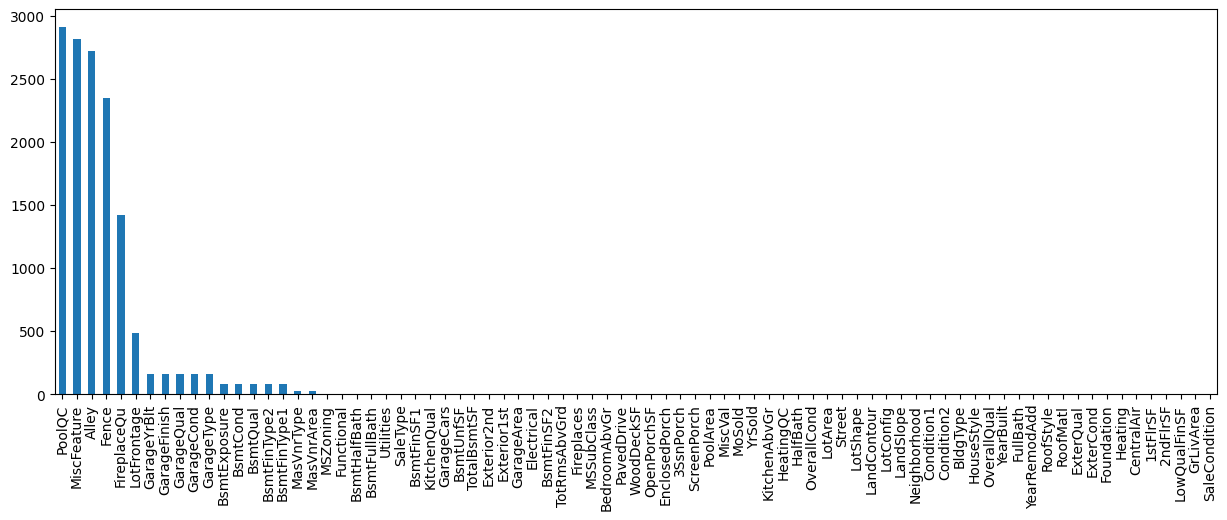

In [123]:
#觀察遺漏值分布
missing = all_data.isnull().sum()
missing.sort_values(inplace=True,ascending = False)
plt.subplots(figsize=(15,5)) # 設定畫面大小
missing.plot.bar()
plt.show()

In [124]:
#觀察遺漏值百分比
null_rate = all_data.isnull().sum() / len(all_data) *100
null_rate.sort_values(ascending = False).head(35)

PoolQC          99.657417
MiscFeature     96.402878
Alley           93.216855
Fence           80.438506
FireplaceQu     48.646797
LotFrontage     16.649538
GarageYrBlt      5.447071
GarageFinish     5.447071
GarageQual       5.447071
GarageCond       5.447071
GarageType       5.378554
BsmtExposure     2.809181
BsmtCond         2.809181
BsmtQual         2.774923
BsmtFinType2     2.740665
BsmtFinType1     2.706406
MasVnrType       0.822199
MasVnrArea       0.787941
MSZoning         0.137033
Functional       0.068517
BsmtHalfBath     0.068517
BsmtFullBath     0.068517
Utilities        0.068517
SaleType         0.034258
BsmtFinSF1       0.034258
KitchenQual      0.034258
GarageCars       0.034258
BsmtUnfSF        0.034258
TotalBsmtSF      0.034258
Exterior2nd      0.034258
Exterior1st      0.034258
GarageArea       0.034258
Electrical       0.034258
BsmtFinSF2       0.034258
TotRmsAbvGrd     0.000000
dtype: float64

In [125]:
#處理遺漏值
for col in ("PoolQC","MiscFeature","Alley","Fence","FireplaceQu"):
    all_data[col] = all_data[col].fillna("None")
#LotFrontage:與房子相連的街道距離，可能與同區域間的房子相似，所以拿Neighborhood同區的中位數當作替代值
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
#GarageCond:車庫條件,GarageQual:車庫等級,GarageFinish:車庫內部裝潢,GarageType:車庫位置
for col in ("GarageCond","GarageQual","GarageFinish","GarageType"):
     all_data[col] = all_data[col].fillna("None")
#GarageYrBlt:車庫建照年份,GarageArea:車庫面積,GarageCars:車庫可容納車子的數量(為數值，所以缺值直接補0)
for col in ("GarageYrBlt","GarageArea","GarageCars"):
    all_data[col] = all_data[col].fillna(0)
#BsmtCond : 地下室的狀況,BsmtExposure:地下室採光程度,BsmtQual:地下室高度,BsmtFinType1:地下室1的等級,BsmtFinType2:地下室2的等級
for col in ("BsmtCond","BsmtExposure","BsmtQual","BsmtFinType1","BsmtFinType2"):
     all_data[col] = all_data[col].fillna("None")
#BsmtFinSF1:地下室1的面積,BsmtFinSF2:地下室2的面積,BsmtHalfBath:地下室半浴室數量,BsmtFullBath:地下室全浴室數量,BsmtUnfSF:未完成的地下室面積,TotalBsmtSF:地下室總面積(為數值，所以缺值直接補0)
for col in ("BsmtFinSF1","BsmtFinSF2","BsmtHalfBath","BsmtFullBath","BsmtUnfSF","TotalBsmtSF",):
    all_data[col] = all_data[col].fillna(0)
#MasVnrType:砌體材質
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
#MasVnrArea:砌體面積
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
#MSZoning:銷售的住宅類型，正常應該要有值，所以這裡應該是真的遺漏掉的值，並非沒有的狀況，所以拿最多的RL(低密度住宅區)來代替
all_data["MSZoning"] = all_data["MSZoning"].fillna(all_data["MSZoning"].mode()[0])
#Functional:家電功能等級，Typ為典型的，也就是一般的，所以2個缺值的部分可以補成Typ
all_data["Functional"] = all_data["Functional"].fillna("Typ")
#Exterior1st,Exterior2nd:房屋外牆飾面，只有1個缺值，所以用最多的數值補
all_data["Exterior1st"] = all_data["Exterior1st"].fillna(all_data["Exterior1st"].mode()[0])
all_data["Exterior2nd"]= all_data["Exterior2nd"].fillna(all_data["Exterior2nd"].mode()[0])
#SaleType:銷售類型，缺值一樣只有一個，所以用最普遍的WD(常規的契約)來替補
all_data["SaleType"] = all_data["SaleType"].fillna(all_data["SaleType"].mode()[0])
#Electrical:電力系統，缺值只有一個，所有用最普遍的SBrkr(標準的電力系統)來替補
all_data["Electrical"] = all_data["Electrical"].fillna(all_data["Electrical"].mode()[0])
#KitchenQual:廚房等級，缺值只有一個，所以用最普遍的TA(典型(中等)的等級)來替補
all_data["KitchenQual"] = all_data["KitchenQual"].fillna(all_data["KitchenQual"].mode()[0])

In [126]:
#刪除沒什麼影響的特徵值
all_data = all_data.drop(['Utilities'],axis=1)

In [127]:
#使用迴圈進行離散值類別處理
train_y = pd.DataFrame(train_data['SalePrice'])
for _ , col in enumerate(all_data.columns.tolist()):
    if all_data[col].dtype == 'object':
        all_data[col] = all_data[col].astype('category').cat.codes
pd.DataFrame(all_data)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,3,65.0,8450,1,1,3,3,4,0,...,0,0,3,4,1,0,2,2008,8,4
2,20,3,80.0,9600,1,1,3,3,2,0,...,0,0,3,4,1,0,5,2007,8,4
3,60,3,68.0,11250,1,1,0,3,4,0,...,0,0,3,4,1,0,9,2008,8,4
4,70,3,60.0,9550,1,1,0,3,0,0,...,0,0,3,4,1,0,2,2006,8,0
5,60,3,84.0,14260,1,1,0,3,2,0,...,0,0,3,4,1,0,12,2008,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,4,21.0,1936,1,1,3,3,4,0,...,0,0,3,4,1,0,6,2006,8,4
2916,160,4,21.0,1894,1,1,3,3,4,0,...,0,0,3,4,1,0,4,2006,8,0
2917,20,3,160.0,20000,1,1,3,3,4,0,...,0,0,3,4,1,0,9,2006,8,0


In [128]:
#檢查缺失值
all_data.isnull().sum().sort_values(ascending = False)

MSSubClass       0
BedroomAbvGr     0
GarageType       0
FireplaceQu      0
Fireplaces       0
                ..
ExterQual        0
MasVnrArea       0
MasVnrType       0
Exterior2nd      0
SaleCondition    0
Length: 78, dtype: int64

In [129]:
#將all_data分割回train_data跟test_data
train_x = all_data[:len(train_data)]
test_x = all_data[len(train_data):]

In [130]:
#進行log轉換
train_y['SalePrice'] = np.log1p(train_y['SalePrice'])
test_y = pd.read_csv(r"C:/Users/123/Documents/VSCode/ML/Kaggle/House_Prices/Dataset/sample_submission.csv")
test_y['SalePrice'] = np.log1p(test_y['SalePrice'])

In [131]:
#模型訓練
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse
#降維成一維，以便隨機森林進行
train_y_v = train_y.values.ravel()
test_y_v= test_y.values.ravel()
train_x.shape,train_y_v.shape,test_x.shape,test_y_v.shape

#隨機迴歸森林
rfr = RandomForestRegressor(n_jobs=-1, n_estimators=100)
rfr.fit(train_x,train_y_v)
 
#極端迴歸森林
etr = ExtraTreesRegressor()
etr.fit(train_x,train_y_v)
 
#梯度提升迴歸樹
gbr = GradientBoostingRegressor()
gbr.fit(train_x,train_y_v)

#線性迴歸
lr = LinearRegression()
lr.fit(train_x,train_y_v)

LinearRegression()

In [132]:
#模型對測試集進行預測，找出RMSE最低的模型
name = ["RandomForestRegressor","ExtraTreesRegressor","GradientBoostingRegressor","LinearRegression"]
model = [rfr,etr,gbr,lr]
for n,m in zip(name,model):
    predict_y = m.predict(test_x)
    predict = pd.DataFrame(predict_y,index = test_y.index,columns = ["SalePrice"])
    score = rmse_cv(m,train_x ,train_y.values.ravel())
    print("{} mean score : {:.4f} ({:.4f})".format(n,score.mean(),score.std()))

RandomForestRegressor mean score : 0.1429 (0.0087)
ExtraTreesRegressor mean score : 0.1376 (0.0138)
GradientBoostingRegressor mean score : 0.1275 (0.0082)
LinearRegression mean score : 0.1515 (0.0282)


In [133]:
#挑選出的模型對測試集進行預測
predict = gbr.predict(test_x)
predict = pd.DataFrame(predict,index=test_y.Id,columns = ["SalePrice"])
predict_true = np.expm1(predict)

In [134]:
#儲存預測結果
predict_true.to_csv(r"for_submission_20230415_2.csv")
predict_true

,SalePrice
Id,
1461,123809.438089
1462,157398.919574
1463,179841.774822
1464,186643.131887
1465,197946.592393
...,...
2915,78306.006251
2916,82129.016090
2917,144640.172987
